In [2]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np

In [3]:
df = pd.read_csv("train (copy).csv")

In [4]:
df.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [5]:
print("Number of Country/Region is", df['Country_Region'].nunique())

print("Countries with Province/State informed are"
      , df[df['Province_State'].isna()==False]['Country_Region'].unique())

Number of Country/Region is 173
Countries with Province/State informed are ['Australia' 'Canada' 'China' 'Denmark' 'France' 'Netherlands' 'US'
 'United Kingdom']


In [6]:
df.describe()

,Id,ConfirmedCases,Fatalities
count,20580.000000,20580.000000,20580.000000
mean,14685.500000,514.939116,21.080952
std,8487.230117,4541.261768,287.758197
min,1.000000,0.000000,0.000000
25%,7335.750000,0.000000,0.000000
50%,14685.500000,0.000000,0.000000
75%,22035.250000,35.000000,0.000000
max,29370.000000,105792.000000,12428.000000


Text(0.5, 0, 'Date')

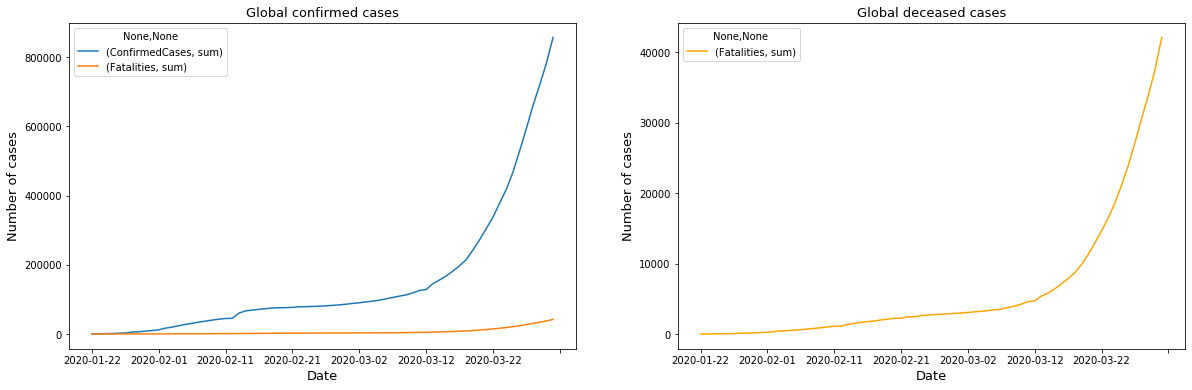

In [7]:
confirmed_dates = df.groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_dates = df.groupby(['Date']).agg({'Fatalities':['sum']})
total_dates = confirmed_dates.join(fatalities_dates)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
total_dates.plot(ax=ax1)
ax1.set_title("Global confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_dates.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

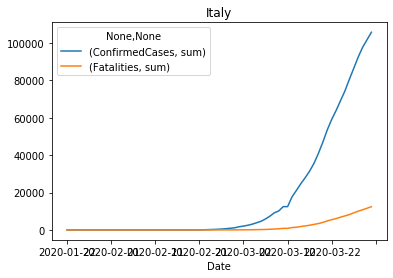

In [8]:
confirmed_total_date_Italy = df[df['Country_Region']=='Italy'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Italy = df[df['Country_Region']=='Italy'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Italy = confirmed_total_date_Italy.join(fatalities_total_date_Italy)
total_date_Italy.plot(ax=plt.gca(), title='Italy')

In [9]:
# building datasets for every country
# &(df['Lat'] == df[df['Country/Region'] == c].Lat.iloc[0])
countries_data = {}
for c in df['Country_Region'].unique():
    countries_data[c]=df[(df['Country_Region'] == c)]
    countries_data[c].insert(0, 'New_ID', countries_data[c].Id - countries_data[c].Id.iloc[0])

In [10]:
countries_data['China']

,New_ID,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
3430,0,4901,Anhui,China,2020-01-22,1.0,0.0
3431,1,4902,Anhui,China,2020-01-23,9.0,0.0
3432,2,4903,Anhui,China,2020-01-24,15.0,0.0
3433,3,4904,Anhui,China,2020-01-25,39.0,0.0
3434,4,4905,Anhui,China,2020-01-26,60.0,0.0
...,...,...,...,...,...,...,...
5735,3265,8166,Zhejiang,China,2020-03-27,1247.0,1.0
5736,3266,8167,Zhejiang,China,2020-03-28,1251.0,1.0
5737,3267,8168,Zhejiang,China,2020-03-29,1254.0,1.0
5738,3268,8169,Zhejiang,China,2020-03-30,1255.0,1.0


In [11]:
pd.set_option('mode.chained_assignment', None)
def build_model(c, target, num): # num representes the day

    data = countries_data[c]
    data.New_ID = data.New_ID - data.New_ID.iloc[0]
    X = np.array(data['New_ID']).reshape(-1, 1)
    y = np.array(data[target])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    scores = []

    for i in range(1, 11):
        print("Euation of "+str(i)+" Degree BEGINS")
        poly = PolynomialFeatures(degree=i)
        poly_x = poly.fit_transform(X_train)
        pol_reg = LinearRegression()
        pol_reg.fit(poly_x, y_train)
        print("Euation of "+str(i)+" Degree Ends with acc = "+str(pol_reg.score(poly.fit_transform(X_test), y_test)*100) + "%")
        scores.append(pol_reg.score(poly.fit_transform(X_test), y_test))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
    ax1.plot(X, y)
    ax1.set_title(c + " confirmed cases", size=13)
    ax1.set_ylabel("Number of cases", size=13)
    ax1.set_xlabel("Date_ID", size=13)
    ax2.plot(range(1, 11), scores, color='orange')
    ax2.set_title("Accuracy vs. Degree", size=13)
    ax2.set_ylabel("Accuracy", size=13)
    ax2.set_xlabel("Degree", size=13)
    
    # finding best degree for each country
    max_ = 0
    max_i = 0
    for index, acc in enumerate(scores):
        if acc > max_:
            max_ = acc
            max_i = index
    print("Best PolynomialDegree is " + str(max_i+1) + " with accuracy " + str(max_*100) + "%")
    max_i += 1
    poly = PolynomialFeatures(degree=max_i)
    poly_x = poly.fit_transform(X_train)
    pol_reg = LinearRegression()
    pol_reg.fit(poly_x, y_train)
    prediction = pol_reg.predict(poly.fit_transform([[num]]))
    return int(prediction)

Euation of 1 Degree BEGINS
Euation of 1 Degree Ends with acc = 40.84226661046985%
Euation of 2 Degree BEGINS
Euation of 2 Degree Ends with acc = 78.16330361189242%
Euation of 3 Degree BEGINS
Euation of 3 Degree Ends with acc = 95.42255774490312%
Euation of 4 Degree BEGINS
Euation of 4 Degree Ends with acc = 99.20023099808637%
Euation of 5 Degree BEGINS
Euation of 5 Degree Ends with acc = 99.17614711682695%
Euation of 6 Degree BEGINS
Euation of 6 Degree Ends with acc = 99.28482098030037%
Euation of 7 Degree BEGINS
Euation of 7 Degree Ends with acc = 99.59287429228405%
Euation of 8 Degree BEGINS
Euation of 8 Degree Ends with acc = 99.7383469067466%
Euation of 9 Degree BEGINS
Euation of 9 Degree Ends with acc = 99.75490154564407%
Euation of 10 Degree BEGINS
Euation of 10 Degree Ends with acc = 99.75309384001638%
Best PolynomialDegree is 9 with accuracy 99.75490154564407%


26

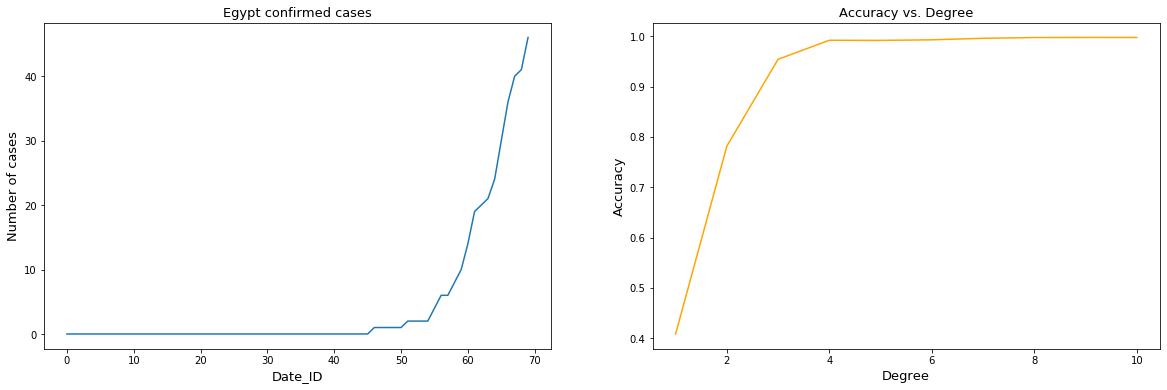

In [12]:
build_model('Egypt', 'Fatalities', 64) # for Egypt

Euation of 1 Degree BEGINS
Euation of 1 Degree Ends with acc = 54.53857366192325%
Euation of 2 Degree BEGINS
Euation of 2 Degree Ends with acc = 90.81792143306656%
Euation of 3 Degree BEGINS
Euation of 3 Degree Ends with acc = 99.56163941406447%
Euation of 4 Degree BEGINS
Euation of 4 Degree Ends with acc = 99.63607735747779%
Euation of 5 Degree BEGINS
Euation of 5 Degree Ends with acc = 99.83243053779829%
Euation of 6 Degree BEGINS
Euation of 6 Degree Ends with acc = 99.84392661002059%
Euation of 7 Degree BEGINS
Euation of 7 Degree Ends with acc = 99.80062623832629%
Euation of 8 Degree BEGINS
Euation of 8 Degree Ends with acc = 99.82958051733786%
Euation of 9 Degree BEGINS
Euation of 9 Degree Ends with acc = 99.84865833566377%
Euation of 10 Degree BEGINS
Euation of 10 Degree Ends with acc = 99.85380216577207%
Best PolynomialDegree is 10 with accuracy 99.85380216577207%


490

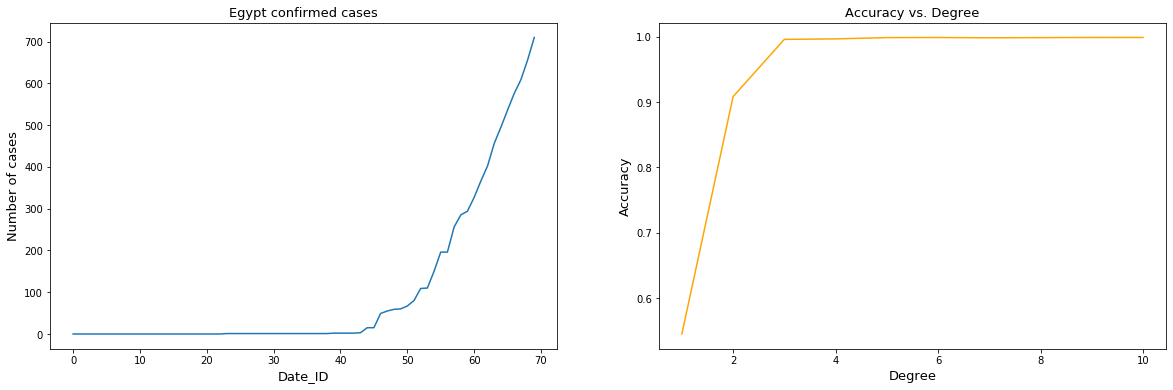

In [13]:
build_model('Egypt', 'ConfirmedCases', 64) # for Egypt

Euation of 1 Degree BEGINS
Euation of 1 Degree Ends with acc = 30.378437377961408%
Euation of 2 Degree BEGINS
Euation of 2 Degree Ends with acc = 86.01878332228733%
Euation of 3 Degree BEGINS
Euation of 3 Degree Ends with acc = 98.92773198609258%
Euation of 4 Degree BEGINS
Euation of 4 Degree Ends with acc = 99.07451565663438%
Euation of 5 Degree BEGINS
Euation of 5 Degree Ends with acc = 99.41708408398668%
Euation of 6 Degree BEGINS
Euation of 6 Degree Ends with acc = 99.83784536627476%
Euation of 7 Degree BEGINS
Euation of 7 Degree Ends with acc = 99.92302819798931%
Euation of 8 Degree BEGINS
Euation of 8 Degree Ends with acc = 99.91895164791654%
Euation of 9 Degree BEGINS
Euation of 9 Degree Ends with acc = 99.93823240255753%
Euation of 10 Degree BEGINS
Euation of 10 Degree Ends with acc = 99.94784636954945%
Best PolynomialDegree is 10 with accuracy 99.94784636954945%


57791

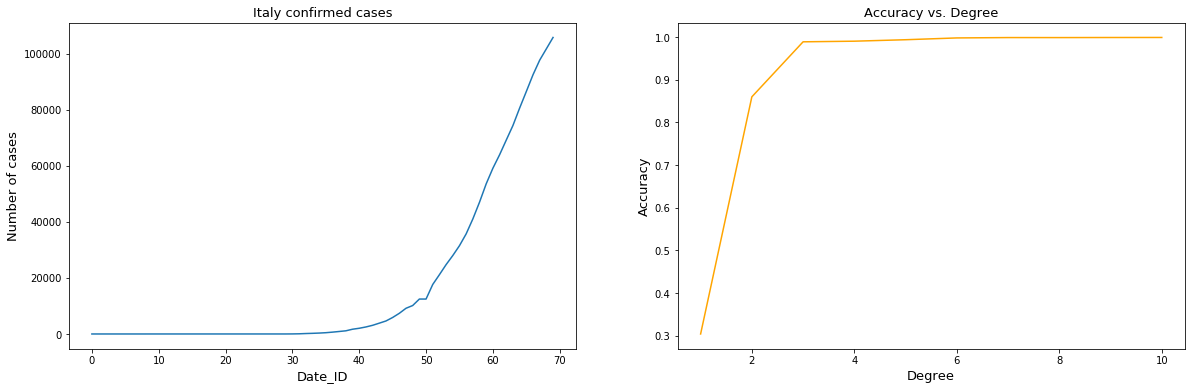

In [14]:
build_model('Italy','ConfirmedCases', 60)

Euation of 1 Degree BEGINS
Euation of 1 Degree Ends with acc = 56.81860455190362%
Euation of 2 Degree BEGINS
Euation of 2 Degree Ends with acc = 87.53376794042077%
Euation of 3 Degree BEGINS
Euation of 3 Degree Ends with acc = 99.13480072127717%
Euation of 4 Degree BEGINS
Euation of 4 Degree Ends with acc = 99.64275281083337%
Euation of 5 Degree BEGINS
Euation of 5 Degree Ends with acc = 99.72320852725558%
Euation of 6 Degree BEGINS
Euation of 6 Degree Ends with acc = 99.95932119122561%
Euation of 7 Degree BEGINS
Euation of 7 Degree Ends with acc = 99.99034099077613%
Euation of 8 Degree BEGINS
Euation of 8 Degree Ends with acc = 99.9899957748363%
Euation of 9 Degree BEGINS
Euation of 9 Degree Ends with acc = 99.99348884092858%
Euation of 10 Degree BEGINS
Euation of 10 Degree Ends with acc = 99.99491049605122%
Best PolynomialDegree is 10 with accuracy 99.99491049605122%


5343

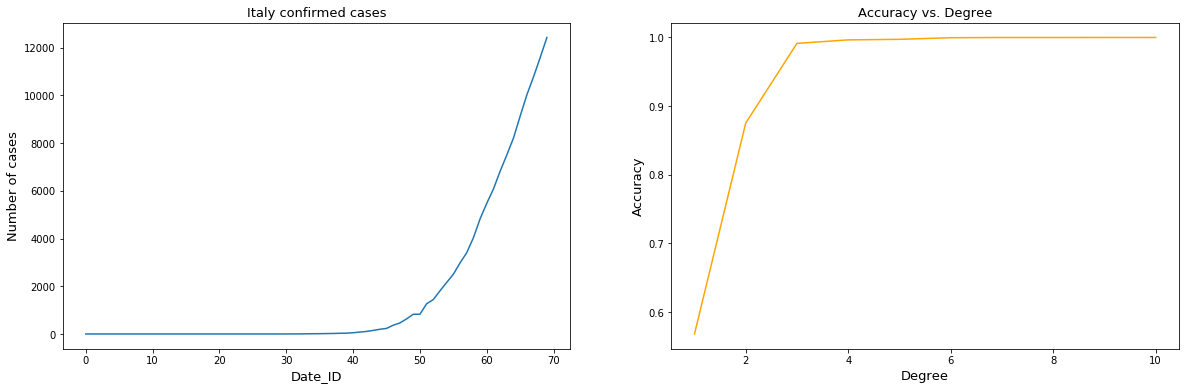

In [15]:
build_model('Italy','Fatalities', 60)

In [16]:
def build_model_reduced(c, target, num): # num representes the day

    data = countries_data[c]
    data.New_ID = data.New_ID - data.New_ID.iloc[0]
    X = np.array(data['New_ID']).reshape(-1, 1)
    y = np.array(data[target])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    scores = []

    for i in range(1, 11):
        poly = PolynomialFeatures(degree=i)
        poly_x = poly.fit_transform(X_train)
        pol_reg = LinearRegression()
        pol_reg.fit(poly_x, y_train)
        scores.append(pol_reg.score(poly.fit_transform(X_test), y_test))
    
    # finding best degree for each country
    max_ = 0
    max_i = 0
    for index, acc in enumerate(scores):
        if acc > max_:
            max_ = acc
            max_i = index
    print("Best PolynomialDegree is " + str(max_i+1) + " with accuracy " + str(max_*100) + "%")
    max_i += 1
    poly = PolynomialFeatures(degree=max_i)
    poly_x = poly.fit_transform(X_train)
    pol_reg = LinearRegression()
    pol_reg.fit(poly_x, y_train)
    prediction = pol_reg.predict(poly.fit_transform([[num]]))
    return int(prediction)


In [17]:
build_model_reduced('Egypt', 'Fatalities', 57)

Best PolynomialDegree is 9 with accuracy 99.71366318989908%


6

In [18]:
# test file reading
dt = pd.read_csv('test (copy).csv')

In [19]:
dt.head()

,ForecastId,Province_State,Country_Region,Date
0,1,NaN,Afghanistan,2020-03-19
1,2,NaN,Afghanistan,2020-03-20
2,3,NaN,Afghanistan,2020-03-21
3,4,NaN,Afghanistan,2020-03-22
4,5,NaN,Afghanistan,2020-03-23


In [20]:
dt.iloc[15, 2], dt.iloc[0, 3]

('Afghanistan', '2020-03-19')

In [22]:
import csv
counter = 57
with open('submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["ForecastId", "ConfirmedCases", "Fatalities"])
    conf_arr = []
    death_arr = []
    for i in range(0, 57):
        conf_arr.append(0)
        death_arr.append(0)
    for i in range(1, len(dt)+1):
        print('writing to ' + str(i) + 'th row')

        conf = abs(build_model_reduced(dt.iloc[i, 2], 'ConfirmedCases', counter))
        death = abs(build_model_reduced(dt.iloc[i, 2], 'Fatalities', counter))
        conf_arr.append(conf)
        death_arr.append(death)
        if(conf_arr[-1] < conf_arr[-2]):
            conf_arr[-1] = conf_arr[-2]
        if(death_arr[-1] < death_arr[-2]):
            death_arr[-1] = death_arr[-2]
        print(counter, [i, conf_arr[-1], death_arr[-1]])
        print(counter, [i, conf_arr[-2], death_arr[-2]])
        writer.writerow([i, conf, death])
        
        if counter == 99:
            counter = 57
            conf_arr = []
            death_arr = []
            for i in range(0, 57):
                conf_arr.append(0)
                death_arr.append(0)
        else:
            counter += 1

writing to 1th row
Best PolynomialDegree is 10 with accuracy 99.15976347783398%
Best PolynomialDegree is 10 with accuracy 88.88118568484647%
57 [1, 24, 0]
57 [1, 0, 0]
writing to 2th row
Best PolynomialDegree is 8 with accuracy 94.96561118551627%
Best PolynomialDegree is 10 with accuracy 93.30426337805828%
58 [2, 31, 0]
58 [2, 24, 0]
writing to 3th row
Best PolynomialDegree is 9 with accuracy 98.2583798877587%
Best PolynomialDegree is 1 with accuracy 0%
59 [3, 39, 1]
59 [3, 31, 0]
writing to 4th row
Best PolynomialDegree is 6 with accuracy 98.42981230861749%
Best PolynomialDegree is 9 with accuracy 96.7353689879945%
60 [4, 43, 1]
60 [4, 39, 1]
writing to 5th row
Best PolynomialDegree is 4 with accuracy 99.27005078098452%
Best PolynomialDegree is 10 with accuracy 87.3033726352617%
61 [5, 57, 1]
61 [5, 43, 1]
writing to 6th row
Best PolynomialDegree is 4 with accuracy 96.89810227187648%
Best PolynomialDegree is 9 with accuracy 97.17607038791863%
62 [6, 67, 1]
62 [6, 57, 1]
writing to 7th

KeyboardInterrupt: 